In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import random
import logging
import re
from tqdm import tqdm
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/ner.csv')
df.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [3]:
df.describe()

,Sentence #,Sentence,POS,Tag
count,47959,47959,47959,47959
unique,47959,47575,47214,33318
top,Sentence: 1,VOA 's Mil Arcega reports .,"['NNP', 'POS', 'NNP', 'NNP', 'VBZ', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
freq,1,17,39,450


In [7]:
df = df.dropna()
df.shape

(47959, 4)

In [11]:
for i, row in df.iterrows():
    txt = row['Sentence']
    tag = literal_eval(row['Tag'])
    if (len(txt.split(' ')) != len(tag)):
        print(i)
        print(txt)
        print(tag)

In [12]:
def get_vocabulary(df, split_str = ' '):
    """
    Return all word2idx, idx2word, tag2idx, idx2tag
    """
    def get_vocab_helper(set_, start_idx = 0):
        set2idx = {}
        idx2set = {}
        i = start_idx
        for s in sorted(set_):
            set2idx[s] = i
            idx2set[i] = s
            i += 1
        return set2idx, idx2set
    
    words = set()
    tags = set()
    for _, row in df.iterrows():
        words.update(row['Sentence'].split(split_str))
        tags.update(literal_eval(row['Tag']))

    word2idx, idx2word = get_vocab_helper(words, start_idx=1)
    tag2idx, idx2tag = get_vocab_helper(tags)

    return word2idx, idx2word, tag2idx, idx2tag

In [13]:
word2idx, idx2word, tag2idx, idx2tag = get_vocabulary(df)

In [14]:
WORDS = len(word2idx.keys())+1 # 1 unknown word
TAGS = len(tag2idx.keys())
print(f"Vocab size: {WORDS}")
print(f"Number of tags: {TAGS}")

Vocab size: 35179
Number of tags: 17


In [15]:
MAXLEN = len(max(df['Sentence'].values, key=lambda x:len(x.split(' '))).split(' '))
print(f"Maximum length of any sentence is : {MAXLEN}")

Maximum length of any sentence is : 104


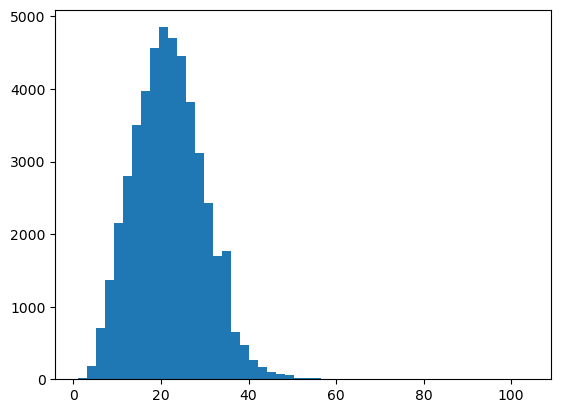

In [21]:
# Make a histogram of sentence lengths
plt.hist([len(s.split(' ')) for s in df['Sentence'].values], bins=50)
plt.show()

In [22]:
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [28]:
for tag, idx in tag2idx.items():
    print(f"{tag} : {idx}")
    
EMPTY_TAG = tag2idx['O']

B-art : 0
B-eve : 1
B-geo : 2
B-gpe : 3
B-nat : 4
B-org : 5
B-per : 6
B-tim : 7
I-art : 8
I-eve : 9
I-geo : 10
I-gpe : 11
I-nat : 12
I-org : 13
I-per : 14
I-tim : 15
O : 16


In [37]:
def get_data(word2idx, tag2idx, df, maxlen = 64, split_str = ' '):
    X = []
    y = []
    for _, row in df.iterrows():
        X.append([word2idx[w] for w in row['Sentence'].split(split_str)])
        y.append([tag2idx[t] for t in literal_eval(row['Tag'])])
    
    X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')
    y = pad_sequences(y, maxlen=maxlen, padding='post', truncating='post', value=tag2idx['O'])
    
    return X, y

In [30]:
X, y = get_data(word2idx, tag2idx, df)

In [31]:
X.shape, y.shape

((47959, 64), (47959, 64))

In [38]:
y_oh = to_categorical(y, num_classes=TAGS)

In [39]:
y_oh.shape

(47959, 64, 17)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.1, random_state=42)

In [41]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout
from keras.models import Model

In [42]:
def build_model(input_shape, vocab_size = 35179, emb_size = 32, maxlen = 64, n_tags = 17):

    sentence_indices = Input(shape=input_shape, dtype='int32')

    X = Embedding(input_dim=vocab_size, output_dim=emb_size, input_length=maxlen)(sentence_indices)

    # Since we need output for every time step, return_sequences = True
    # It will return both output as well as activation
    X = Bidirectional(LSTM(units = 128, return_sequences = True))(X)

    X = Dropout(0.5)(X)

    # Since we need output for every time step, return_sequences = True
    X = Bidirectional(LSTM(units = 64, return_sequences = True))(X)

    X = Dropout(0.5)(X)

    X = TimeDistributed(Dense(n_tags, activation="softmax"))(X)

    model = Model(inputs=sentence_indices, outputs=X)

    return model

In [170]:
model = build_model(input_shape=(64, ))

In [171]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 64, 32)            1125728   
                                                                 
 bidirectional_8 (Bidirecti  (None, 64, 256)           164864    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 64, 256)           0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 64, 128)           164352    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 64, 128)           0   

In [163]:
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import keras.backend as K

In [172]:
# Use f1 score as metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [165]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(43163, 64) (43163, 64, 17)
(4796, 64) (4796, 64, 17)


In [173]:
history = model.fit(X, y_oh, batch_size=64, epochs=100)

Epoch 1/100
750/750 [==============================] - 107s 137ms/step - loss: 0.1907 - accuracy: 0.9574
Epoch 2/100
750/750 [==============================] - 103s 138ms/step - loss: 0.0660 - accuracy: 0.9811
Epoch 3/100
750/750 [==============================] - 103s 137ms/step - loss: 0.0435 - accuracy: 0.9880
Epoch 4/100
750/750 [==============================] - 103s 137ms/step - loss: 0.0360 - accuracy: 0.9900
Epoch 5/100
750/750 [==============================] - 103s 137ms/step - loss: 0.0315 - accuracy: 0.9912
Epoch 6/100
750/750 [==============================] - 102s 136ms/step - loss: 0.0282 - accuracy: 0.9920
Epoch 7/100
750/750 [==============================] - 102s 136ms/step - loss: 0.0256 - accuracy: 0.9927
Epoch 8/100
750/750 [==============================] - 102s 136ms/step - loss: 0.0233 - accuracy: 0.9933
Epoch 9/100
750/750 [==============================] - 103s 138ms/step - loss: 0.0214 - accuracy: 0.9937
Epoch 10/100
750/750 [==============================] -

In [180]:
def plot_history_metric(history, metric, epochs = 20):
    epochs_li = list(range(1, epochs+1))
    train_metric = history.history[metric]
    # val_metric = history.history['val_'+metric]
    plt.plot(epochs_li, train_metric, 'b', label=f"Training {metric}")
    # plt.plot(epochs_li, val_metric, 'b', label=f"Validation {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.show()

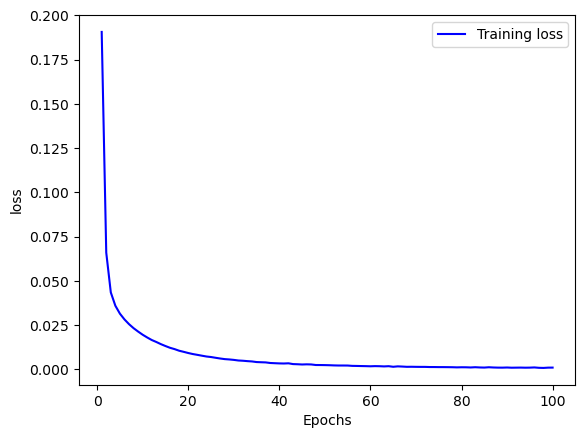

In [181]:
plot_history_metric(history, 'loss', epochs = 100)

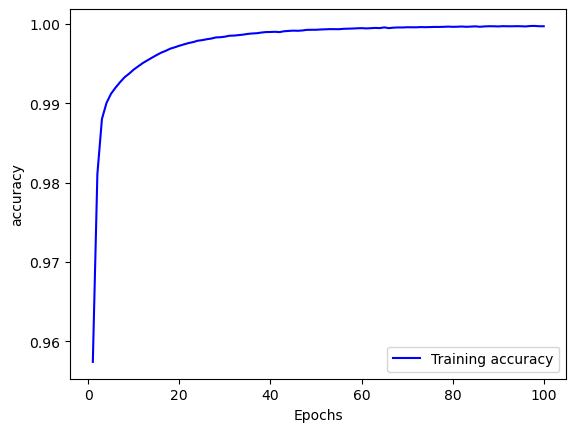

In [182]:
plot_history_metric(history, 'accuracy', epochs = 100)

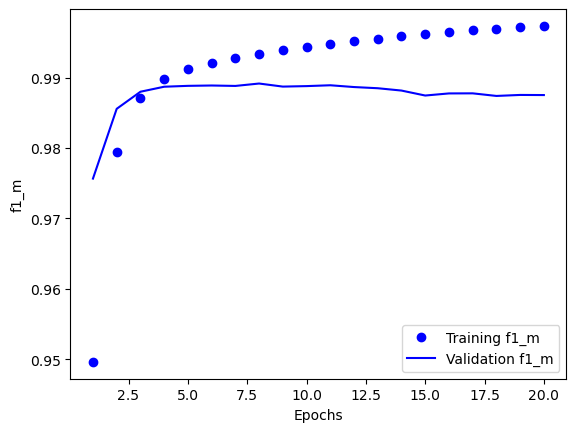

In [101]:
# Plot f1 score
plot_history_metric(history, 'f1_m')

In [210]:
# Test an example sentence
test_sentence = "Manohar Lal Khattar is the chief minister of Haryana."
test_sentence = test_sentence.split(' ')
# If word is not in vocab then use 0 index for that word
test_sentence = [word2idx.get(w, 0) for w in test_sentence]
test_sentence = pad_sequences([test_sentence], maxlen=64, padding='post', truncating='post')
test_sentence

array([[    0,  9387,     0, 25446, 33247, 19338, 26841, 27701,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)

In [211]:
# Predict
pred = model.predict(test_sentence)
pred = np.argmax(pred, axis=-1)
# Convert to tags
pred = [idx2tag[i] for i in pred[0]]
print(pred)

1/1 [==============================] - 0s 32ms/step
['O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [189]:
y_pred = model.predict(X_test)
y_pred_tags = np.argmax(y_pred, axis=-1)
y_test_tags = np.argmax(y_test, axis=-1)

150/150 [==============================] - 6s 40ms/step


In [103]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Accuracy: {accuracy_score(y_test_tags.flatten(), y_pred_tags.flatten())}")

Accuracy: 0.9872712937864887


In [104]:
confusion_matrix(y_test_tags.flatten(), y_pred_tags.flatten())

array([[     3,      0,      4,      0,      0,     11,      2,      2,
             0,      0,      0,      0,      0,      1,      1,      0,
            17],
       [     1,      5,      6,      2,      1,      4,      0,      0,
             0,      2,      0,      0,      0,      1,      0,      0,
             3],
       [     0,      0,   3405,     43,      0,    148,     43,     18,
             1,      0,     44,      1,      0,     16,     17,      8,
           150],
       [     1,      2,     61,   1446,      0,     18,      2,      0,
             0,      0,      1,      2,      0,      0,      0,      0,
             9],
       [     0,      0,      0,      0,      8,      1,      1,      1,
             0,      0,      0,      0,      1,      0,      0,      0,
            16],
       [     6,      3,    293,     27,      1,   1351,     48,      3,
             1,      1,      8,      0,      0,     44,     20,      1,
           181],
       [     4,      2,     66,   

In [105]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

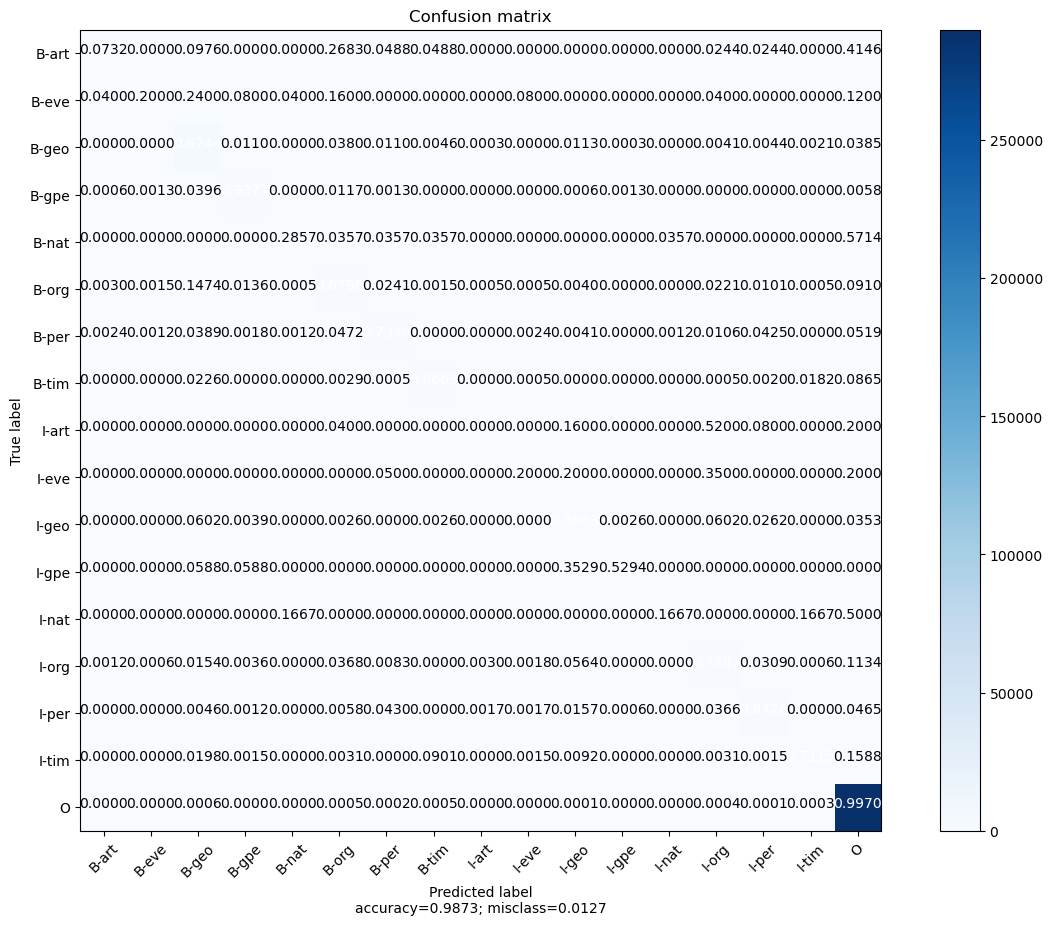

In [106]:
tags = list(tag2idx.keys())
plot_confusion_matrix(confusion_matrix(y_test_tags.flatten(), y_pred_tags.flatten()), tags)

In [179]:
model.save('ner_full_dataset.keras')

In [110]:
%ls -al

total 34560
drwxrwxr-x 3 co21btech11001 co21btech11001     4096 Dec 21 06:56 ./
drwxrwxr-x 9 co21btech11001 co21btech11001     4096 Dec 20 07:58 ../
-rw-rw-r-- 1 co21btech11001 co21btech11001        0 Dec 21 06:13 bi_rnn.py
drwxrwxr-x 2 co21btech11001 co21btech11001     4096 Dec 20 07:58 data/
-rw-rw-r-- 1 co21btech11001 co21btech11001 17554330 Dec 21 05:28 ner_accuracy.keras
-rw-rw-r-- 1 co21btech11001 co21btech11001 17562612 Dec 21 06:56 ner.keras
-rw-rw-r-- 1 co21btech11001 co21btech11001   255419 Dec 21 06:01 notebook_bi_rnn.ipynb
-rw-rw-r-- 1 co21btech11001 co21btech11001        0 Dec 21 06:29 notebook_transformers.ipynb


In [169]:
# Find f1 score for test data
f1_score(y_test_tags.flatten(), y_pred_tags.flatten(), average = None)

array([0.09677419, 0.22222222, 0.84775302, 0.93622532, 0.35555556,
       0.70327954, 0.81771307, 0.87335812, 0.        , 0.18604651,
       0.76143387, 0.5625    , 0.18181818, 0.75484466, 0.85327845,
       0.74440895, 0.99669813])

In [ ]:
# The bes theoretical f1 score is 1.0